In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Установка необходимых библиотек
!pip install segmentation_models_pytorch albumentations nibabel

In [ ]:
# Импорт библиотек
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
import nibabel as nib
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import random
import time
import cv2

Датасет: [3D Liver segmentation](https://www.kaggle.com/datasets/prathamgrover/3d-liver-segmentation?resource=download)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
root = "/content/drive/MyDrive/Сегментация печени/Task03_Liver_rs"

# Получение данных о датасете

In [ ]:
im_paths = glob(f"{root}/imagesTr/*.nii")
gt_paths = glob(f"{root}/labelsTr/*.nii")
print(f'Количество стоковых nii файлов: {len(im_paths)}')
print(f'Количество размеченных файлов: {len(gt_paths)}')

Количество стоковых nii файлов: 123
Количество размеченных файлов: 123


In [ ]:
im_total_counter = 0
gt_total_counter = 0
for i in range(len(im_paths)):
  if i % 10 == 0:
    print(f'{i}/{len(im_paths)}')

  im_total_counter += len(nib.load(im_paths[i]).get_fdata().transpose(2, 1, 0))
  gt_total_counter += len(nib.load(gt_paths[i]).get_fdata().transpose(2, 1, 0))

  if i == len(im_paths):
    print(f'{i}/{len(im_paths)}')

0/123
10/123
20/123
30/123
40/123
50/123
60/123
70/123
80/123
90/123
100/123
110/123
120/123


In [ ]:
print(f'В среднем в стоковых nii файлах {round(im_total_counter / len(im_paths), 2)} срезов. Всего {im_total_counter} срезов')
print(f'В среднем в размеченных файлах {round(gt_total_counter / len(gt_paths), 2)} срезов. Всего {gt_total_counter} срезов')

В среднем в стоковых nii файлах 159.38 срезов. Всего 19604 срезов
В среднем в размеченных файлах 159.38 срезов. Всего 19604 срезов


# Предобработка входных данных

In [ ]:
class CustomSegmentationDataset(Dataset):

    def __init__(self, root, transformations=None):
        im_nii_paths = sorted(glob(f"{root}/imagesTr/*.nii"))
        gt_nii_paths = sorted(glob(f"{root}/labelsTr/*.nii"))

        self.ims = []
        self.gts = []

        for index, (im_nii, gt_nii) in enumerate(zip(im_nii_paths, gt_nii_paths)):
            # if index == 50:
            #     break
            print(f"Конвертация Nifti файла номер {index + 1}...")
            nii_im_data, nii_gt_data = self.read_nii(im_nii, gt_nii)

            for im, gt in zip(nii_im_data, nii_gt_data):
                if len(np.unique(gt)) == 2:
                    self.ims.append(im)
                    self.gts.append(gt)

        self.transformations = transformations
        self.n_cls = 2

        assert len(self.ims) == len(self.gts)

    def __len__(self):
        return len(self.ims)

    def __getitem__(self, idx):
        im, gt = self.ims[idx], self.gts[idx]
        if self.transformations:
            im, gt = self.apply_transformations(im, gt)

        im = self.preprocess_im(im)
        gt[gt > 1] = 1

        return im.float(), gt.unsqueeze(0).float()

    def preprocess_im(self, im):
        max_val = torch.max(im)
        im[im < 0] = 0
        return im / max_val

    def read_nii(self, im, gt):
        return nib.load(im).get_fdata().transpose(2, 1, 0), nib.load(gt).get_fdata().transpose(2, 1, 0)

    def apply_transformations(self, im, gt):
        transformed = self.transformations(image=im, mask=gt)
        return transformed["image"], transformed["mask"]


In [ ]:
def get_dataloader(root, transformations, batch_size, split=[0.9, 0.05, 0.05], num_workers=4):
    assert sum(split) == 1., "Сумма долей должна быть равна 1"
    ds = CustomSegmentationDataset(root=root, transformations=transformations)

    # Минимальные размеры для каждого подмножества
    tr_len = max(int(len(ds) * split[0]), 1)
    val_len = max(int(len(ds) * split[1]), 1)
    test_len = max(len(ds) - (tr_len + val_len), 1)

    # Корректировка, если общая сумма превышает длину набора данных
    if tr_len + val_len + test_len > len(ds):
        tr_len = len(ds) - val_len - test_len

    torch.manual_seed(42)
    tr_ds, val_ds, test_ds = random_split(ds, [tr_len, val_len, test_len])
    tr_dl = DataLoader(dataset=tr_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
    val_dl = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)
    test_dl = DataLoader(dataset=test_ds, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=True)
    return tr_dl, val_dl, test_dl, ds.n_cls

In [ ]:
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose([A.Resize(im_h, im_w), ToTensorV2(transpose_mask=True)])
tr_dl, val_dl, test_dl, n_cls = get_dataloader(root=root, transformations=trans, batch_size=16)

Конвертация Nifti файла номер 1...
Конвертация Nifti файла номер 2...
Конвертация Nifti файла номер 3...
Конвертация Nifti файла номер 4...
Конвертация Nifti файла номер 5...
Конвертация Nifti файла номер 6...
Конвертация Nifti файла номер 7...
Конвертация Nifti файла номер 8...
Конвертация Nifti файла номер 9...
Конвертация Nifti файла номер 10...
Конвертация Nifti файла номер 11...
Конвертация Nifti файла номер 12...
Конвертация Nifti файла номер 13...
Конвертация Nifti файла номер 14...
Конвертация Nifti файла номер 15...
Конвертация Nifti файла номер 16...
Конвертация Nifti файла номер 17...
Конвертация Nifti файла номер 18...
Конвертация Nifti файла номер 19...
Конвертация Nifti файла номер 20...
Конвертация Nifti файла номер 21...
Конвертация Nifti файла номер 22...
Конвертация Nifti файла номер 23...
Конвертация Nifti файла номер 24...
Конвертация Nifti файла номер 25...
Конвертация Nifti файла номер 26...
Конвертация Nifti файла номер 27...
Конвертация Nifti файла номер 28...
К

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Функция обработки маски снимка для получения контура

In [ ]:
def find_contours(mask):
    mask = mask.squeeze(0)
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()

    mask = (mask > 0).astype(np.uint8) * 255

    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # RETR_EXTERNAL - поиск только внешних контуров
    # CHAIN_APPROX_SIMPLE - упрощение контура удалением лишних точек
    # RETR_TREE -
    contour_mask = np.zeros_like(mask)

    cv2.drawContours(contour_mask, contours, -1, (255), thickness=1)
    return contour_mask

Функции для визуализации

In [ ]:
def plot_image(ax, image):
    ax.imshow(image.squeeze(0).cpu().numpy(), cmap='gray')
    ax.set_title("Оригинальное изображение")
    ax.axis("off")

def plot_gt(ax, gt_image):
    ax.imshow(gt_image.squeeze(0).cpu().numpy(), cmap='gray')
    ax.set_title("GT маска (правильная маска)")
    ax.axis("off")

def plot_pred(ax, pred_image):
    ax.imshow(pred_image.squeeze(0).cpu().numpy(), cmap='gray')
    ax.set_title("Предсказанная маска")
    ax.axis("off")

def plot_contour_gt(ax, contour_gt):
    contour_gt = find_contours(contour_gt)

    ax.imshow(contour_gt, cmap='gray')
    ax.set_title('Контур GT-маски')
    ax.axis('off')

def plot_contour_pred(ax, contour_pred):
    contour_pred = find_contours(contour_pred)

    ax.imshow(contour_pred, cmap='gray')
    ax.set_title('Контур предсказанной маски')
    ax.axis('off')

def visualize_dataset(dataloader, num_images, model=None):
    columns = 3
    if model:
      columns = 5
      model.eval()
    fig, axes = plt.subplots(num_images, columns, figsize=(20, 25))

    for i, batch in enumerate(dataloader):
        if i >= num_images:
            break
        images, gt = batch
        images = images.to(device)
        if model:
            with torch.no_grad():
                # preds = torch.argmax(model(images), dim=1)
                preds = torch.sigmoid(model(images)) > 0.5

                plot_pred(axes[i, 3], preds[0])
                plot_contour_pred(axes[i, 4], preds[0])

        plot_image(axes[i, 0], images[0])
        plot_gt(axes[i, 1], gt[0])
        plot_contour_gt(axes[i, 2], gt[0])


    plt.tight_layout()
    plt.show()

Визуализация данных из датасета

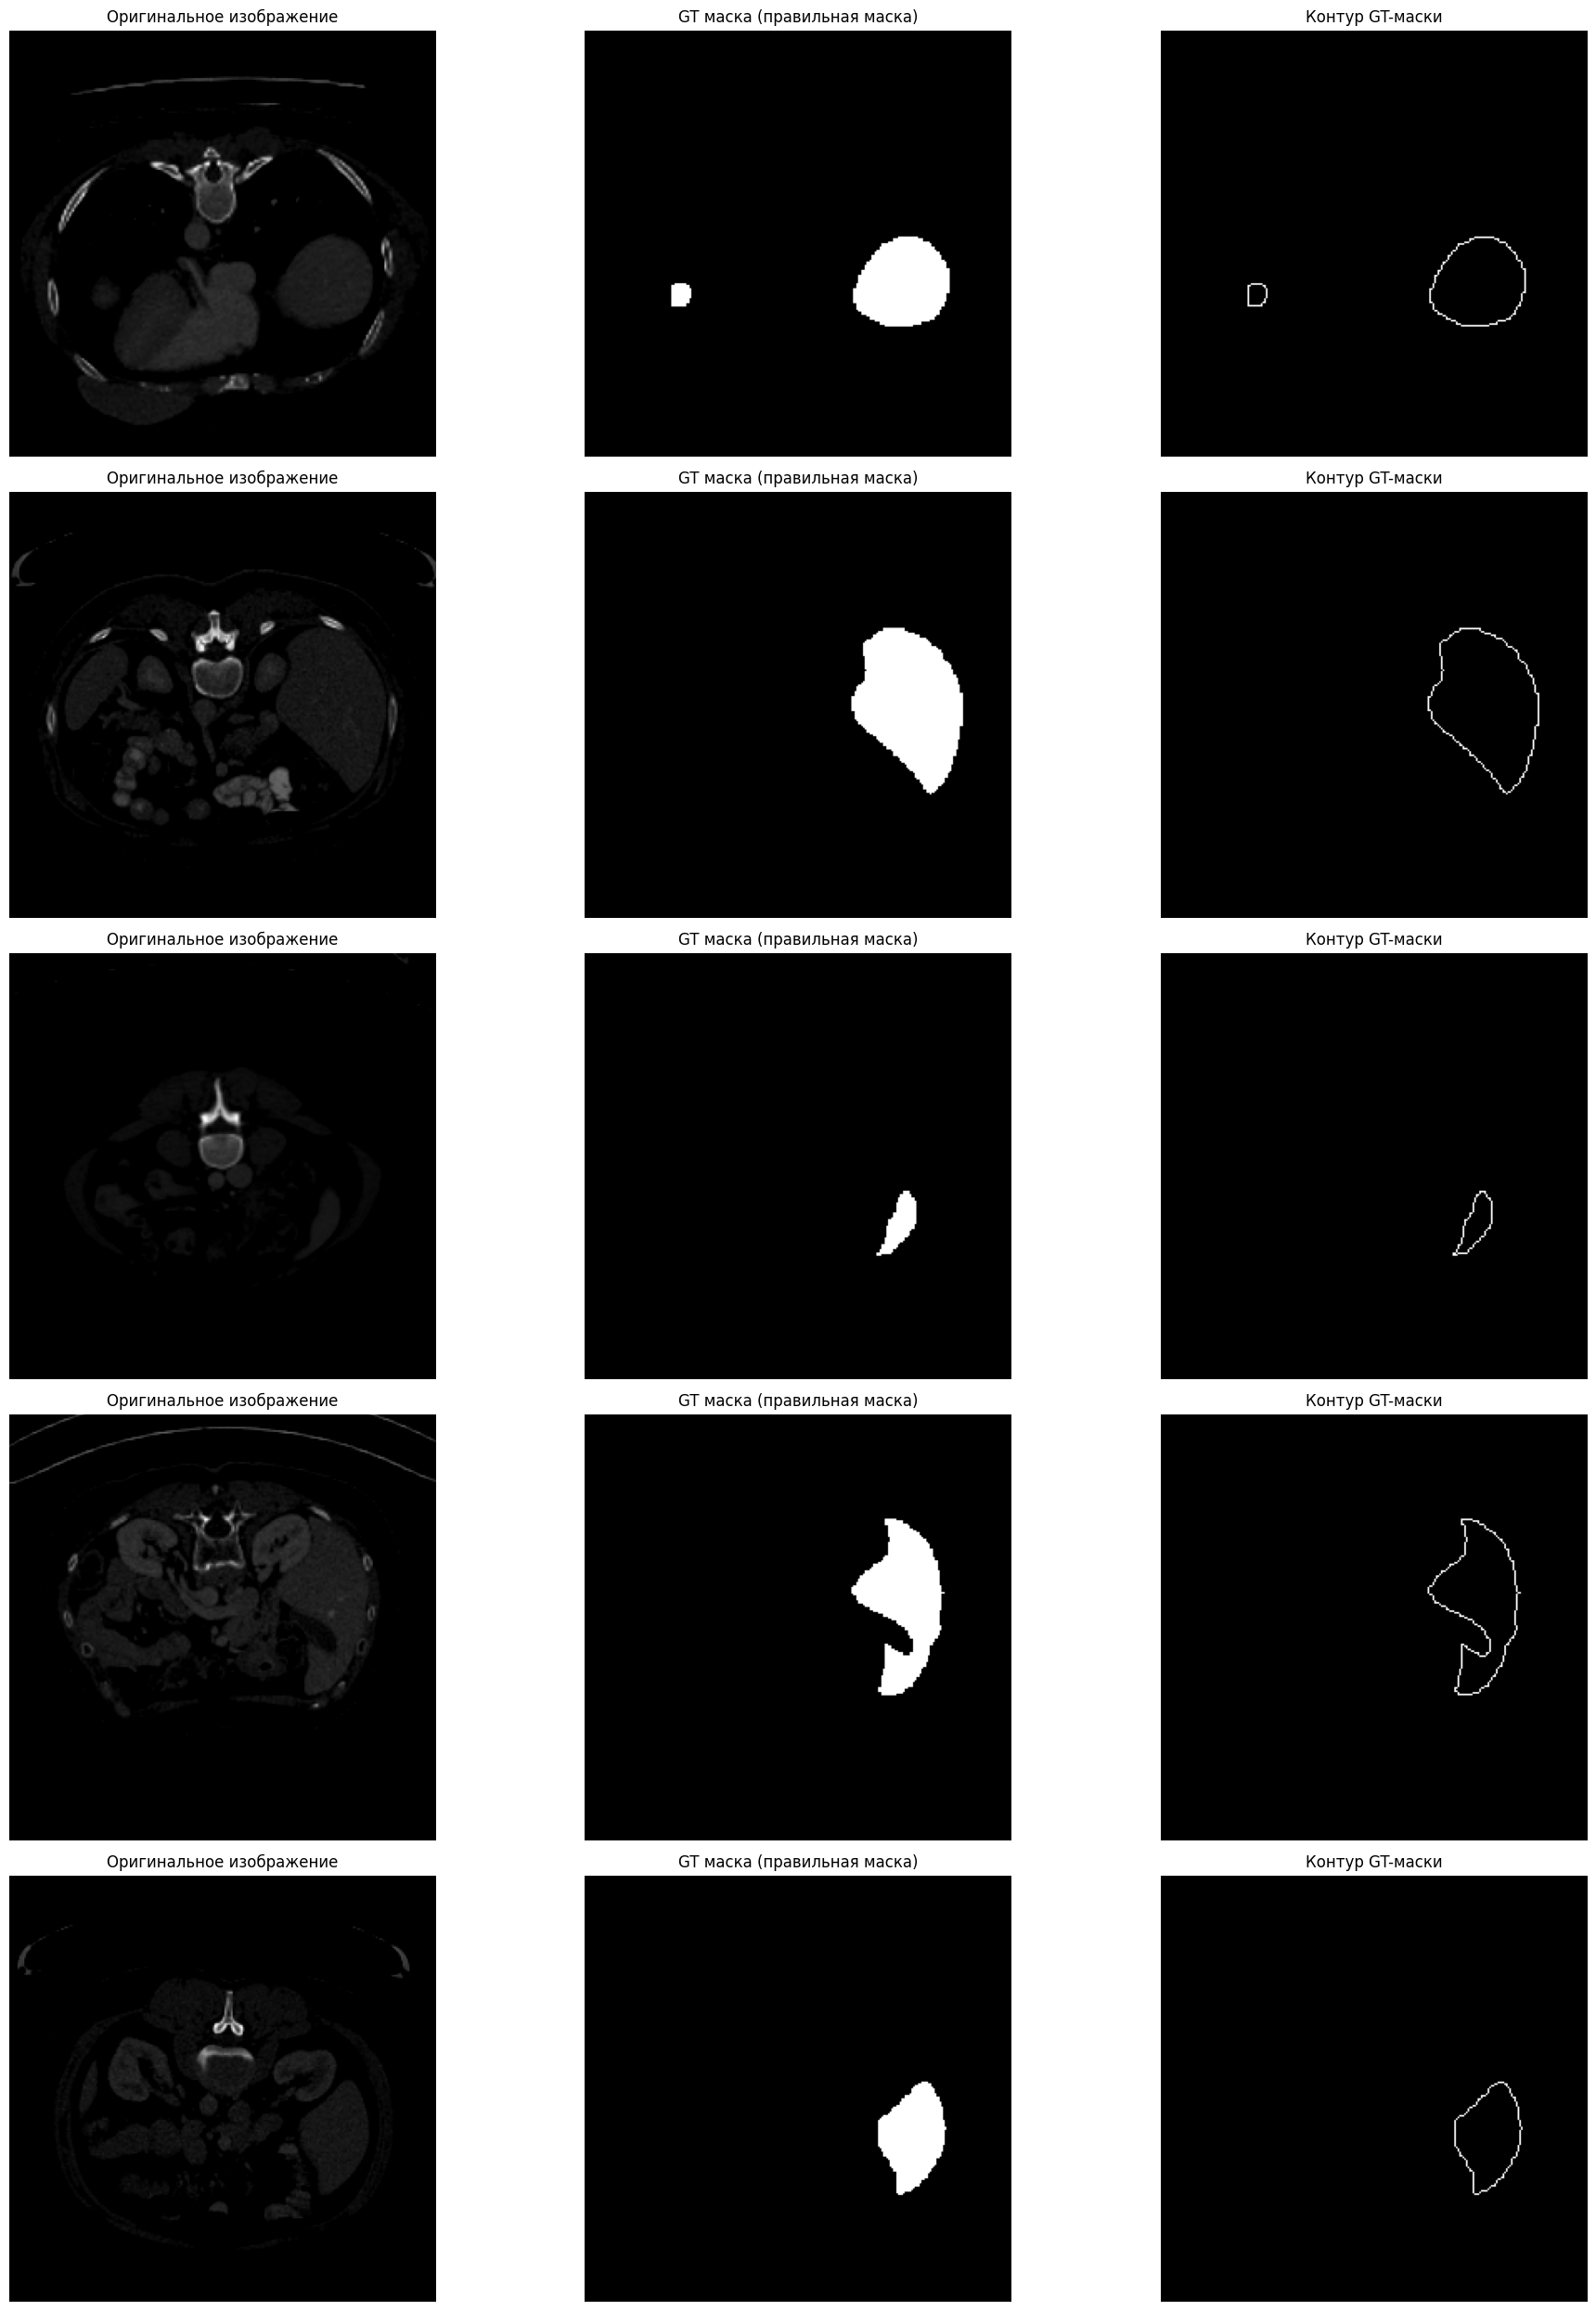

In [ ]:
visualize_dataset(tr_dl, num_images=5)

# Опеределение модели, функции потерь и оптимизатора

In [ ]:
# Определение модели, функции потерь и оптимизатора
model = smp.DeepLabV3Plus(classes=1, in_channels=1)
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.BCEWithLogitsLoss() # бинарная кросс-энтропия
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)

# ioU
# Функционал для обведения контура

model.to(device)

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

# Обучение модели

In [ ]:
# Параметры обучения
epochs = 50
best_val_loss = float('inf')
best_model_wts = None
history = {
    'train_loss': [],
    'val_loss': [],
}

# Цикл обучения
print("Начало обучения")
for epoch in range(1, epochs + 1):
    start_time = time.time()
    model.train()
    train_loss = 0
    print(f"\nЭпоха {epoch}")
    for batch in tr_dl:
        images, targets = batch
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    end_time = time.time()
    train_loss = train_loss / len(tr_dl)
    history['train_loss'].append(train_loss)
    print("Train Loss:", round(train_loss, 4))
    print(f"Время на эпоху: {round(end_time - start_time, 2)} секунд")

    # Валидация
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dl:
            images, targets = batch
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()
    val_loss = val_loss / len(val_dl)
    history['val_loss'].append(val_loss)
    print("Validation Loss:", round(val_loss, 4))

    # Сохранение лучших весов модели
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict()

# Загрузка лучших весов модели
# if best_model_wts:
#     model.load_state_dict(best_model_wts)


Начало обучения

Эпоха 1
Train Loss: 0.0794
Время на эпоху: 51.01 секунд
Validation Loss: 0.0266

Эпоха 2
Train Loss: 0.0204
Время на эпоху: 49.8 секунд
Validation Loss: 0.0198

Эпоха 3
Train Loss: 0.0145
Время на эпоху: 50.07 секунд
Validation Loss: 0.0166

Эпоха 4
Train Loss: 0.012
Время на эпоху: 50.65 секунд
Validation Loss: 0.0129

Эпоха 5
Train Loss: 0.0104
Время на эпоху: 52.4 секунд
Validation Loss: 0.0116

Эпоха 6
Train Loss: 0.0092
Время на эпоху: 51.05 секунд
Validation Loss: 0.0111

Эпоха 7
Train Loss: 0.0085
Время на эпоху: 51.41 секунд
Validation Loss: 0.0104

Эпоха 8
Train Loss: 0.008
Время на эпоху: 51.07 секунд
Validation Loss: 0.0101

Эпоха 9
Train Loss: 0.0076
Время на эпоху: 51.19 секунд
Validation Loss: 0.0105

Эпоха 10
Train Loss: 0.0125
Время на эпоху: 51.0 секунд
Validation Loss: 0.0115

Эпоха 11
Train Loss: 0.0085
Время на эпоху: 51.13 секунд
Validation Loss: 0.0101

Эпоха 12
Train Loss: 0.0073
Время на эпоху: 51.12 секунд
Validation Loss: 0.0097

Эпоха 13
Trai

## График истории обучения

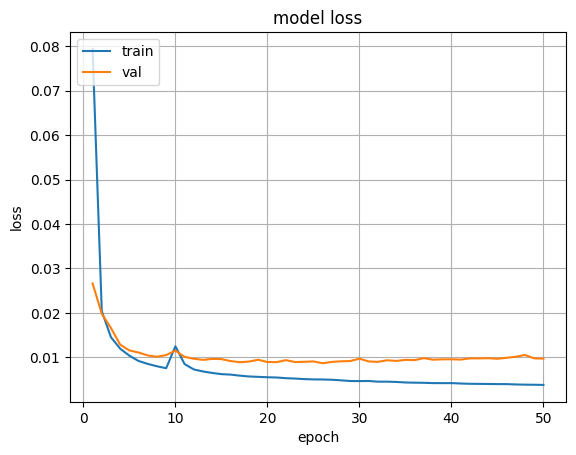

In [ ]:
x_range = np.arange(1, epochs + 1)

plt.plot(x_range, history['train_loss'], label='train')
plt.plot(x_range, history['val_loss'], label='val')

# plt.xticks(np.arange(1, len(history['train_loss'])+1, step=step))
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()

# Отображение графика
plt.show()

Сохранение модели

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Сегментация печени/model4.pth')

# Расчёт метрик для оценки моделей

In [ ]:
# state_dict = torch.load('/content/drive/MyDrive/Сегментация печени/model4.pth', map_location=device)
# model = smp.DeepLabV3Plus(classes=1, in_channels=1)
# model.load_state_dict(state_dict)
# model.to(device)
# model.eval()

## Расчёт индекса Жакара

In [ ]:
def calculate_jaccard_index(pred, gt):
    intersection = torch.logical_and(gt, pred).sum().item()
    union = torch.logical_or(gt, pred).sum().item()
    if union == 0:
      return 1.0 if intersection == 0 else 0.0
    return intersection / union

jaccard_indices = []
for batch in test_dl:
    images, targets = batch
    images, targets = images.to(device), targets.to(device)
    with torch.no_grad():
        outputs = model(images)
    # preds = torch.argmax(outputs, dim=1)
    preds = torch.sigmoid(outputs) > 0.5
    for pred, gt in zip(preds, targets):
        jaccard_index = calculate_jaccard_index(pred, gt)
        jaccard_indices.append(jaccard_index)
average_jaccard_index = np.mean(jaccard_indices)
print("Индекс Жакара:", round(average_jaccard_index, 2))

Индекс Жакара: 0.91


## Расчёт IoU

In [ ]:
def calculate_iou(pred, gt):
    tp, fp, fn = 0, 0, 0
    for i in range(len(gt)):
        for j in range(len(gt[0])):
            if gt[i][j] == True and pred[i][j] == True:
                tp += 1
            elif gt[i][j] == False and pred[i][j] == True:
                fp += 1
            elif gt[i][j] == True and pred[i][j] == False:
                fn += 1

    try:
        iou = tp / (tp + fp + fn)
    except ZeroDivisionError:
        return 0
    return iou

In [ ]:
# def calculate_iou_contour(pred, gt):
#     pred_contour = find_contours(pred)
#     gt_contour = find_contours(gt)

#     return calculate_iou(pred_contour, gt_contour)

In [ ]:
iou_full = 0
# iou_contour = 0
counter = 0

for batch in test_dl:
    images, targets = batch
    images, targets = images.to(device), targets.to(device)

    with torch.no_grad():
        outputs = model(images)

    preds = torch.sigmoid(outputs) > 0.5
    for pred, gt in zip(preds, targets):
        pred_np = pred.squeeze(0).cpu().numpy().astype(bool)
        gt_np = gt.squeeze(0).cpu().numpy().astype(bool)

        iou_full += calculate_iou(pred_np, gt_np)
        # iou_contour += calculate_iou_contour(pred, gt)
        counter += 1
try:
    iou_avg_full = iou_full / counter
except ZeroDivisionError:
    iou_avg_full = 0

# try:
#     iou_avg_contour = iou_contour / counter
# except ZeroDivisionError:
#     iou_avg_contour = 0

In [ ]:
print(f'IoU полная маска: {round(iou_avg_full, 2)}')
# print(f'IoU контур: {round(iou_avg_contour, 2)}')

IoU полная маска: 0.91


## Коробочный IoU

In [ ]:
from torchvision.ops import box_iou, masks_to_boxes

In [ ]:
iou_box_full = 0
counter = 0

for batch in test_dl:
    images, targets = batch
    images, targets = images.to(device), targets.to(device)

    with torch.no_grad():
        outputs = model(images)

    preds = torch.sigmoid(outputs) > 0.5

    if not torch.any(preds):
        iou_box_full += 0
    else:
        pred_boxes = masks_to_boxes(preds.squeeze(1))
        gt_boxes = masks_to_boxes(targets.squeeze(1))
        iou_box_full += box_iou(pred_boxes, gt_boxes).mean().item()

    counter += 1

iou_avg_box_full = iou_box_full / counter if counter > 0 else 0

    # for pred, gt in zip(preds, targets):
    #     pred_np = pred.squeeze(0).cpu().numpy().astype(bool)
    #     gt_np = gt.squeeze(0).cpu().numpy().astype(bool)
    #     iou_box_full += box_iou(pred_np, gt_np)
    #     counter += 1

# try:
#     iou_avg_box_full = iou_box_full / counter
# except ZeroDivisionError:
#     iou_avg_box_full = 0


In [ ]:

print(f'IoU коробочный полная маска: {round(iou_avg_box_full, 2)}')

IoU коробочный полная маска: 0.91


## Результаты

In [ ]:
print("Индекс Жакара:", round(average_jaccard_index, 2))
print(f'IoU полная маска: {round(iou_avg_full, 2)}')
print(f'IoU коробочный полная маска: {round(iou_avg_box_full, 2)}')

Индекс Жакара: 0.91
IoU полная маска: 0.91
IoU коробочный полная маска: 0.91


# Визуализация оригинального изображения GT-маски и предсказанной маски

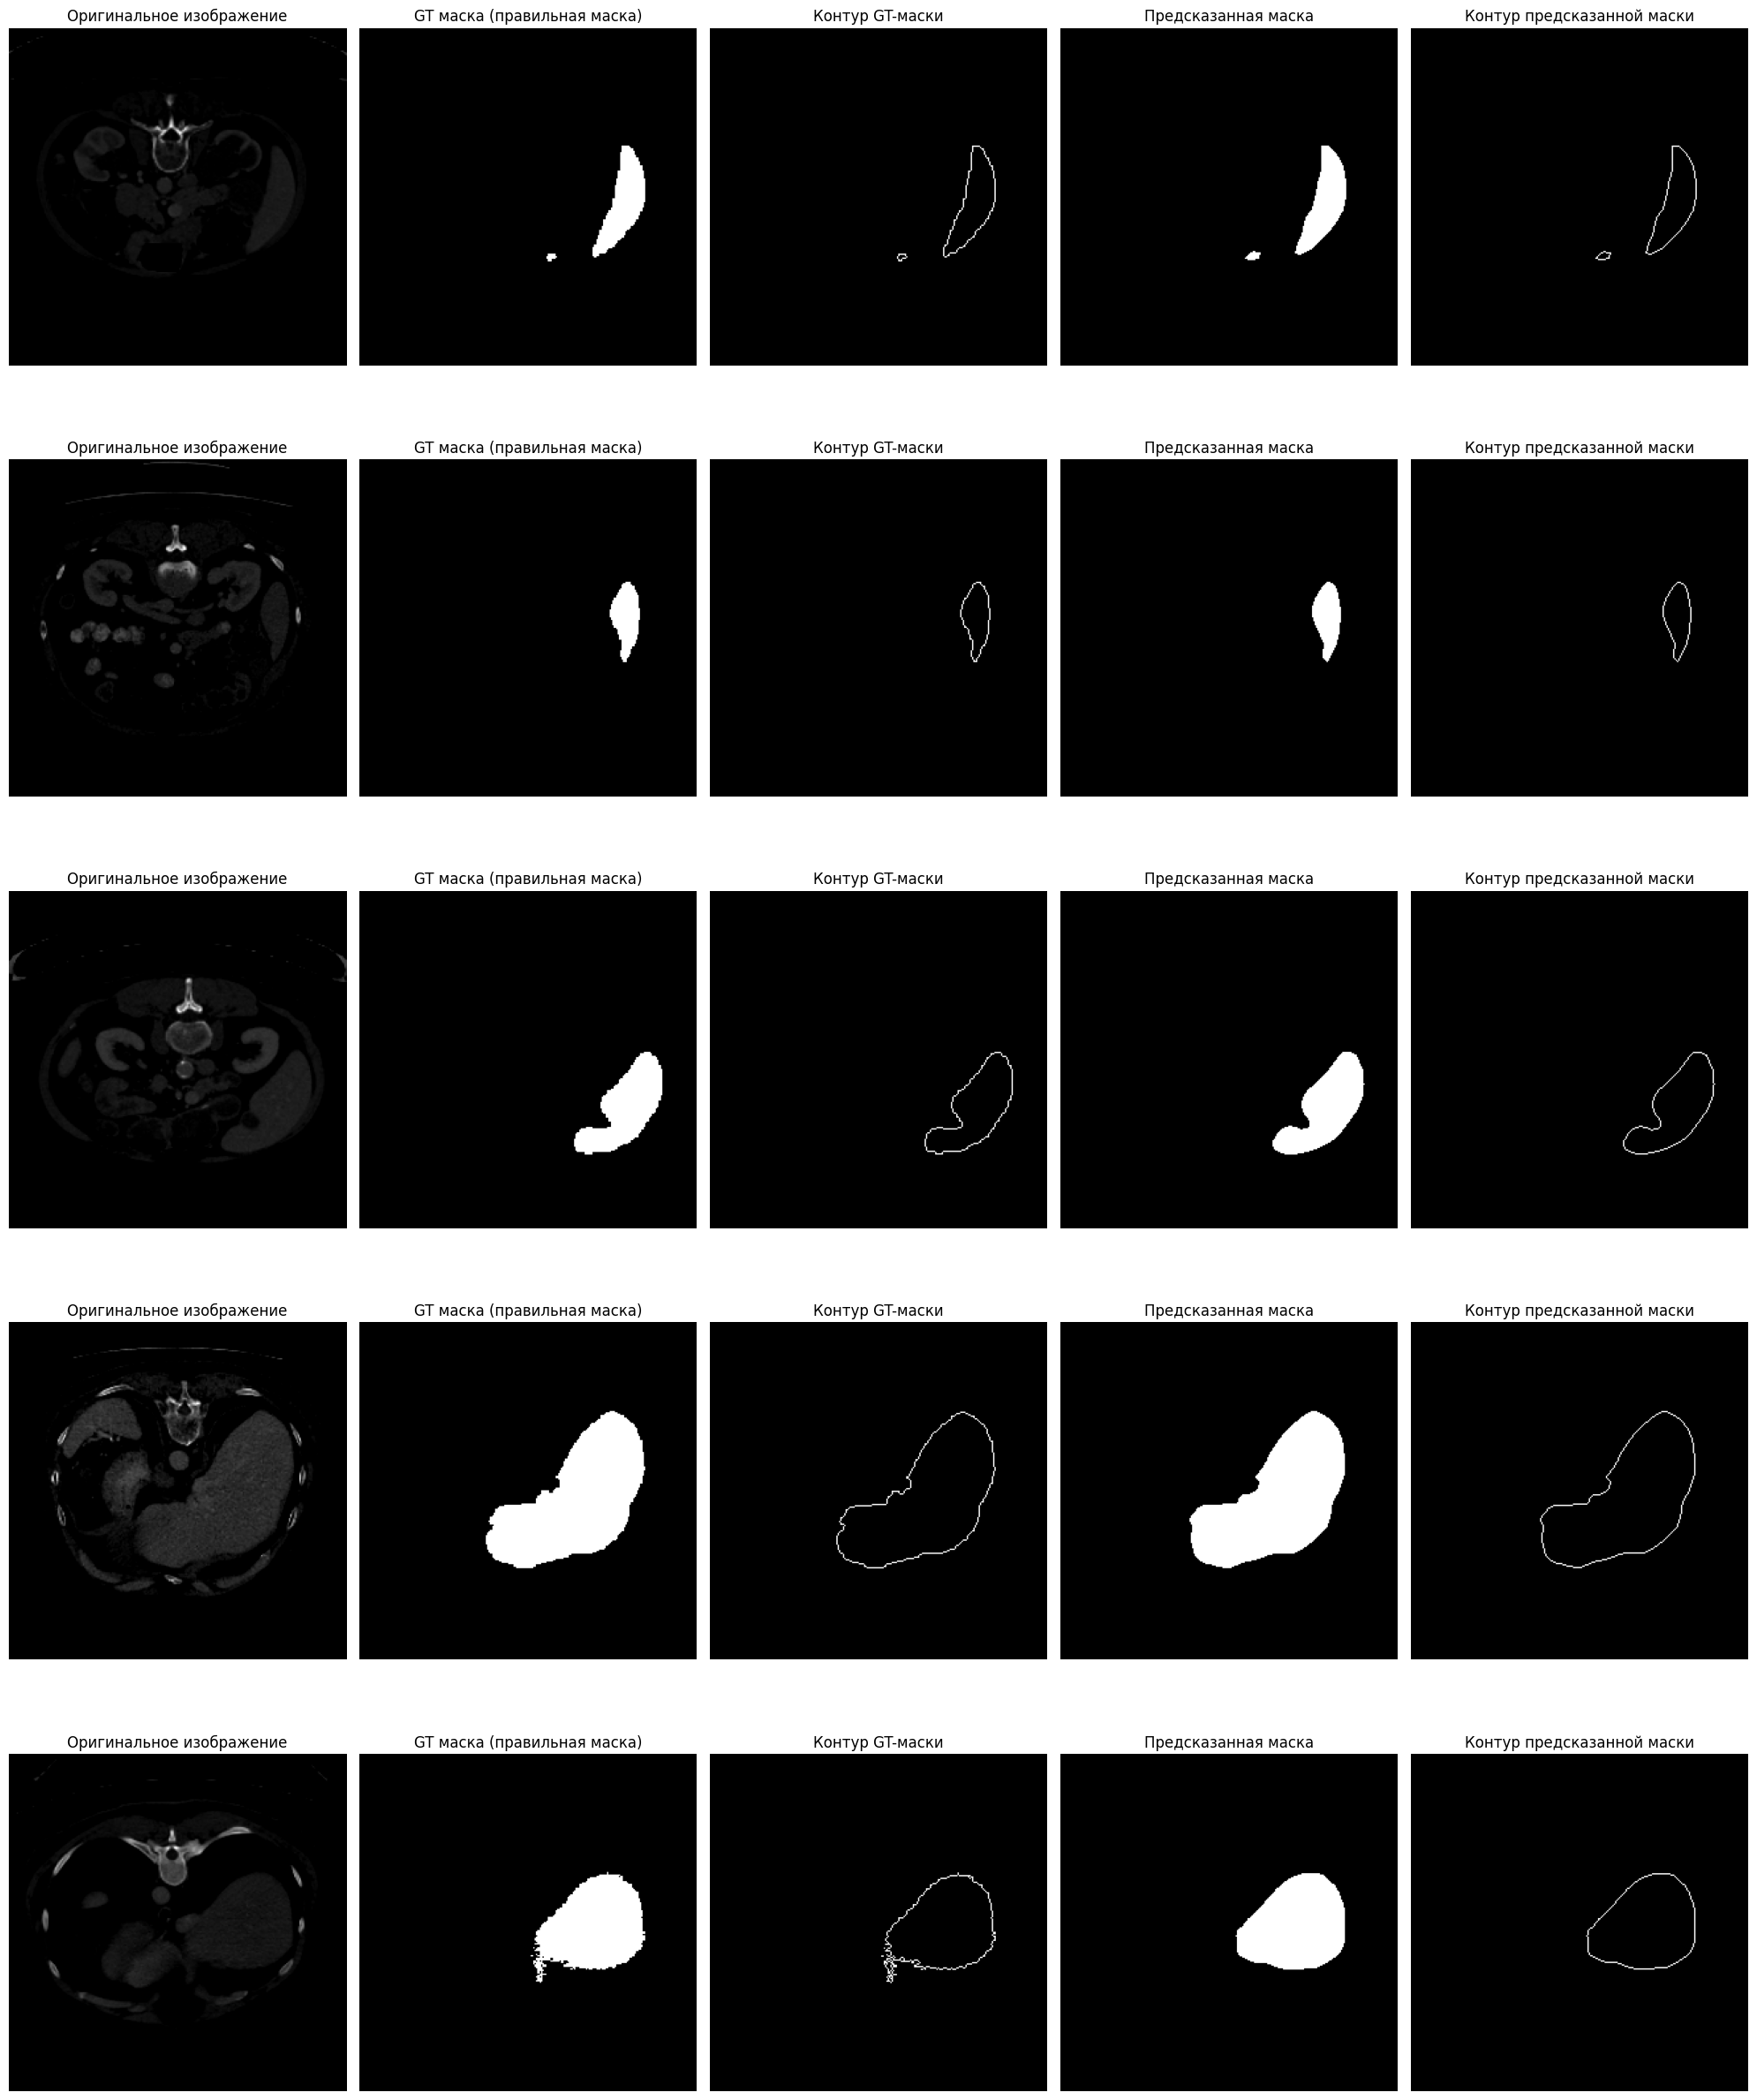

In [ ]:
visualize_dataset(test_dl, num_images=5, model=model)